In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import nltk
import re
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Load files

In [2]:
wine_reviews = pd.read_csv("no-punctuation-digit/wine-reviews-no-punc-digits.csv")
wine_reviews.head()

,Unnamed: 0,Unnamed: 0.1,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,logit_score
0,0,0,Italy,Aromas include tropical fruit broom brimstone ...,Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,0
1,1,1,Portugal,This is ripe and fruity a wine that is smooth ...,Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,0
2,2,2,US,Tart and snappy the flavors of lime flesh and ...,NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,0
3,3,3,US,Pineapple rind lemon pith and orange blossom s...,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,0
4,4,4,US,Much like the regular bottling from this come...,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,0


#### Find wines written by same reviewers as Vino Verde

In [ ]:
wine_reviews_VV_rev = wine_reviews[wine_reviews['taster_name'].isin(wine_reviews[wine_reviews['province'] \
                                            == 'Vinho Verde']['taster_name'].unique())]

In [3]:
wine_reviews_VV = wine_reviews[wine_reviews['province'] == 'Vinho Verde']

In [ ]:
len(wine_reviews_VV_rev)

In [4]:
len(wine_reviews_VV)

382

### Train-test split

In [8]:
#use a specific seed for reproducibility
train, test = train_test_split(wine_reviews_VV, random_state = 1337)

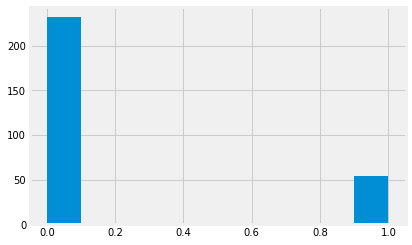

In [9]:
train['logit_score'].hist()

In [10]:
len(train[train['logit_score'] == 1])/len(train)

0.1888111888111888

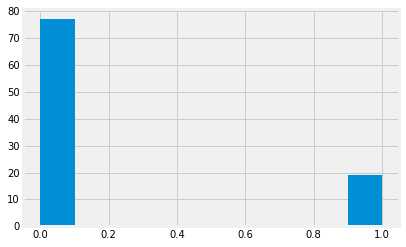

In [11]:
test['logit_score'].hist()

In [12]:
len(test[test['logit_score'] == 1])/len(test)

0.19791666666666666

Hence, the split of train good and bad is roughly the same percentage as the split of test good and bad. 

In [13]:
text_train = np.array(train['description'])
y_train = np.array(train['logit_score'])

In [14]:
text_test = np.array(test['description'])
y_test = np.array(test['logit_score'])

### Save training and test files if needed

In [15]:
#np.savetxt("text_train.csv", text_train, fmt="%s", encoding='utf-8')
#np.savetxt("y_train.csv", y_train)
#np.savetxt("text_test.csv", text_test, fmt="%s", encoding='utf-8')
#np.savetxt("y_test.csv", y_test)

### Vectorize and tokenize words

#### Stemming

In [16]:
from nltk.stem.porter import PorterStemmer
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [17]:
tokenize('acidic')

['acid']

#### CountVectorizer vs TfidfVectorizer

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = ['a', 'an', 'the', 'from', 'of']
#vect = CountVectorizer(min_df = 5, ngram_range=(1, 2))
vect = TfidfVectorizer(min_df = 5, ngram_range=(1, 2), lowercase=True, \
                       stop_words= 'english', tokenizer = tokenize)
X_train = vect.fit(text_train).transform(text_train)
X_test = vect.transform(text_test)

print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("X_train:\n{}".format(repr(X_train)))
print("X_test: \n{}".format(repr(X_test)))

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Vocabulary size: 318
X_train:
<286x318 sparse matrix of type '<class 'numpy.float64'>'
	with 5871 stored elements in Compressed Sparse Row format>
X_test: 
<96x318 sparse matrix of type '<class 'numpy.float64'>'
	with 1800 stored elements in Compressed Sparse Row format>
Number of features: 318


# Logistic Regression

### Train the model

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
param_grid = {'C': [0.01, 0.1]} #tested before and found out C = 0.1 is best
start = time()
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
end = time()
tot = end - start
print("Total Time taken: ", tot)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Total Time taken:  0.05424690246582031
Best cross-validation score: 0.81
Best parameters:  {'C': 0.01}
Best estimator:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Check coefficient values of specific words

In [20]:
test_word = 'sweet'

In [21]:
for i in range(len(feature_names)):
    if(feature_names[i]  == test_word):
        idx = i
        print(idx)
        break

251


In [22]:
feature_names[idx]

'sweet'

In [23]:
grid.best_estimator_.coef_[0][idx]

-0.04103872625260438

### Plot top 20 words (both + and -)

In [ ]:
import mglearn

mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=20)
plt.savefig("word_association_no-punc_tfid_logit.png", dpi = 250, bbox_inches = 'tight')

### Check performance statistics

In [24]:
lr = grid.best_estimator_
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

Score: 0.80


In [25]:
y_pred = grid.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8020833333333334


In [27]:
from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred))

0.0


In [28]:
#C00 = true neg, C10 = false neg, C11 = true pos, C01 = false pos
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[77,  0],
       [19,  0]], dtype=int64)

In [29]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

In [30]:
from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred))

0.0


C:\Users\tanve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, '2-class Precision-Recall curve"')

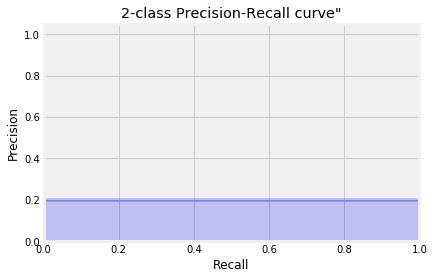

In [31]:
from sklearn.utils.fixes import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve"')

### Check random reviews

In [ ]:
rev = ["The nose is currently a bit closed, eventually offering shades of red and blue berries. The palate has more to tell, giving way to flavors of juicy cranberry and tart blueberry, with a gentle hug of tannins providing support."]

In [ ]:
print("rev prediction: {}". format(lr.predict(vect.transform(rev))))

### Summary of no punctuation vs no punctuation + digit

No punctuation:
-   accuracy: 0.848
-   score: 0.85
-   conf_matrix: [[16760, 1904], [2656, 8669]]

# SVM

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
param_grid = {'C': [0.01, 0.1]}
grid = GridSearchCV(LinearSVC(), param_grid, cv=5)
#grid = GridSearchCV(SVC(kernel = 'linear'), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.82
Best parameters:  {'C': 0.1}
Best estimator:  LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [ ]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=25)
plt.savefig("word_association_no-punc_tfid_svm.png", dpi = 250, bbox_inches = 'tight')

In [33]:
lr = grid.best_estimator_
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

Score: 0.81


In [34]:
from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred))

0.0


In [35]:
from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred))

0.0


C:\Users\tanve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
rev = ["Roasted, earthy berry aromas come with notes of latex and Band-Aid. This Merlot feels saucy and soupy, without much structure. Herbal plum and raspberry flavors finish with lighter but similar flavors."]

In [ ]:
print("rev prediction: {}". format(lr.predict(vect.transform(rev))))

# Neural Networks

In [36]:
import string
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
# fix random seed for reproducibility
np.random.seed(7)

In [33]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    ## Stemming
    text = text.split()
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)

    return text

In [26]:
#find longest review word number
maxlen = np.max([len(x.split()) for x in wine_reviews['description'].tolist()])

In [27]:
### Create sequence
vocabulary_size = 10000 
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(train['description'])

sequences = tokenizer.texts_to_sequences(train['description'])
X_train = pad_sequences(sequences, maxlen=maxlen)
y_train = train['logit_score']

In [28]:
X_train.shape

(89966, 134)

In [29]:
### Create sequence for X_test
vocabulary_size = 10000 
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(train['description'])

sequences = tokenizer.texts_to_sequences(test['description'])
X_test = pad_sequences(sequences, maxlen=maxlen)
y_test = test['logit_score']

In [30]:
X_test.shape

(29989, 134)

In [39]:
# apply cleaning function to test and train texts

train['description'] = train['description'].map(lambda x: clean_text(x))
test['description'] = test['description'].map(lambda x: clean_text(x))

C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [234]:
## Network architecture
embedding_vec_length = 32

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_vec_length, input_length=maxlen))
model.add(LSTM(embedding_vec_length, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [235]:
## Fit the model

model.fit(X_train, y_train, validation_split=0.4, epochs=3)

Train on 53979 samples, validate on 35987 samples
Epoch 1/3
53979/53979 [==============================] - 66s 1ms/step - loss: 0.4110 - acc: 0.8071 - val_loss: 0.3629 - val_acc: 0.8336
Epoch 2/3
53979/53979 [==============================] - 75s 1ms/step - loss: 0.3397 - acc: 0.8495 - val_loss: 0.3578 - val_acc: 0.8371
Epoch 3/3
53979/53979 [==============================] - 69s 1ms/step - loss: 0.3130 - acc: 0.8627 - val_loss: 0.3668 - val_acc: 0.8328


In [236]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.34%


## CNN + LSTM

##### Model generation

In [238]:
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_vec_length, input_length=maxlen))
model.add(Conv1D(filters=embedding_vec_length, \
                 kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

In [239]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 76, 32)            320000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 32)            3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
_________________________________________________________________


In [175]:
#find longest review word number
print(np.max([len(x.split()) for x in train['description'].tolist()]))
print(np.max([len(x.split()) for x in test['description'].tolist()]))

76
71


In [179]:
### Create sequence
vocabulary_size = 10000 
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(train['description'])

sequences = tokenizer.texts_to_sequences(train['description'])
data = pad_sequences(sequences, maxlen=maxlen)

In [181]:
labels = train['logit_score']

In [183]:
labels.shape

(89966,)

In [184]:
data.shape

(89966, 76)

In [185]:
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        114,    1,  305, 4439,   23,   11,  259,  571,    4, 1030,   20,
          2, 2460,   26,   16,   25,   67,  375,  211,   14,    8])

In [240]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 76, 32)            320000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 32)            3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
_________________________________________________________________
None


In [241]:
model.fit(data, labels, epochs=3, batch_size=64)

Epoch 1/3
89966/89966 [==============================] - 43s 483us/step - loss: 0.3830 - acc: 0.82100s - loss: 0.3834 - acc
Epoch 2/3
89966/89966 [==============================] - 45s 505us/step - loss: 0.3208 - acc: 0.8575
Epoch 3/3
89966/89966 [==============================] - 46s 508us/step - loss: 0.2888 - acc: 0.8736


#### Model evaluation

In [189]:
### Create sequence
vocabulary_size = 10000 
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(test['description'])

sequences = tokenizer.texts_to_sequences(test['description'])
X_test = pad_sequences(sequences, maxlen=maxlen)

In [190]:
y_test = test['logit_score']

In [242]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.72%


### GRU

In [255]:
from keras.layers.recurrent import GRU

In [256]:
## Network architecture
embedding_vec_length = 32

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_vec_length, input_length=maxlen))
model.add(GRU(embedding_vec_length, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [257]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 76, 32)            320000    
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


In [269]:
X_train.shape

(89966, 76)

In [258]:
## Fit the model

model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Train on 53979 samples, validate on 35987 samples
Epoch 1/5
53979/53979 [==============================] - 60s 1ms/step - loss: 0.4300 - acc: 0.7941 - val_loss: 0.3651 - val_acc: 0.8349
Epoch 2/5
53979/53979 [==============================] - 60s 1ms/step - loss: 0.3532 - acc: 0.8424 - val_loss: 0.3587 - val_acc: 0.8367
Epoch 3/5
53979/53979 [==============================] - 57s 1ms/step - loss: 0.3253 - acc: 0.8575 - val_loss: 0.3587 - val_acc: 0.8382
Epoch 4/5
53979/53979 [==============================] - 57s 1ms/step - loss: 0.3043 - acc: 0.8690 - val_loss: 0.3666 - val_acc: 0.8348
Epoch 5/5
53979/53979 [==============================] - 61s 1ms/step - loss: 0.2856 - acc: 0.8784 - val_loss: 0.3776 - val_acc: 0.8315


In [259]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 83.27%


In [261]:
scores

[0.37371957526686683, 0.8327053252899133]

In [262]:
model.predict_classes(X_test)

TypeError: data type not understood

In [266]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)

TypeError: data type not understood

In [268]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 76, 32)            320000    
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


### GRU + CNN

In [229]:
model = Sequential()
model.add(Embedding(vocabulary_size, 32, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(embedding_vec_length))
model.add(Dense(1, activation='sigmoid'))

In [231]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 76, 32)            320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 76, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 329,377
Trainable params: 329,377
Non-trainable params: 0
_________________________________________________________________


In [232]:
## Fit the model

model.fit(X_train, y_train, validation_split=0.4, epochs=3)

Train on 53979 samples, validate on 35987 samples
Epoch 1/3
53979/53979 [==============================] - 31s 574us/step - loss: 0.3992 - acc: 0.8116 - val_loss: 0.3637 - val_acc: 0.8343
Epoch 2/3
53979/53979 [==============================] - 34s 625us/step - loss: 0.3230 - acc: 0.8573 - val_loss: 0.3571 - val_acc: 0.8385
Epoch 3/3
53979/53979 [==============================] - 36s 664us/step - loss: 0.2788 - acc: 0.8798 - val_loss: 0.3893 - val_acc: 0.8286


In [233]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 82.75%


### Deep GRU

In [285]:
## Network architecture
embedding_vec_length = 32

model = Sequential()
model.add(Embedding(vocabulary_size, embedding_vec_length, input_length=maxlen))
model.add(GRU(embedding_vec_length, return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print ('model compiled')
model.summary()

model compiled
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 76, 32)            320000    
_________________________________________________________________
gru_19 (GRU)                 (None, 76, 32)            6240      
_________________________________________________________________
dropout_10 (Dropout)         (None, 76, 32)            0         
_________________________________________________________________
gru_20 (GRU)                 (None, 100)               39900     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 101       
Total params: 366,241
Trainable params: 366,241
Non-trainable params: 0
_______________________________________________________

In [286]:
## Fit the model

model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Train on 89966 samples, validate on 29989 samples
Epoch 1/5
89966/89966 [==============================] - 180s 2ms/step - loss: 0.5058 - acc: 0.7766 - val_loss: 0.3955 - val_acc: 0.8329
Epoch 2/5
89966/89966 [==============================] - 184s 2ms/step - loss: 0.4609 - acc: 0.8004 - val_loss: 0.4196 - val_acc: 0.8213
Epoch 3/5
89966/89966 [==============================] - 183s 2ms/step - loss: 0.3965 - acc: 0.8315 - val_loss: 0.6377 - val_acc: 0.5841
Epoch 4/5
89966/89966 [==============================] - 182s 2ms/step - loss: 0.3868 - acc: 0.8260 - val_loss: 0.4250 - val_acc: 0.8281
Epoch 5/5
89966/89966 [==============================] - 176s 2ms/step - loss: 0.3841 - acc: 0.8199 - val_loss: 0.4712 - val_acc: 0.7954


In [287]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.54%


In [288]:
model.predict(X_test)

TypeError: data type not understood

### HAN

In [46]:
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence
import nltk
import re
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

In [19]:
#attention layer
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [75]:
#config
max_features=10000
max_senten_len=72
max_senten_num=2
embed_size=100
VALIDATION_SPLIT = 0.2

In [76]:
paras = []
labels = []
texts = []

In [77]:
sent_lens = []
sent_nums = []
for idx in range(wine_reviews['description'].shape[0]):
    text = wine_reviews['description'][idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

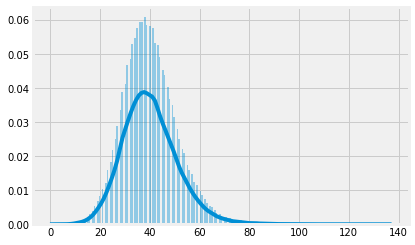

In [78]:
sns.distplot(sent_lens, bins=200)
plt.show()

C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\tanve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\tanve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


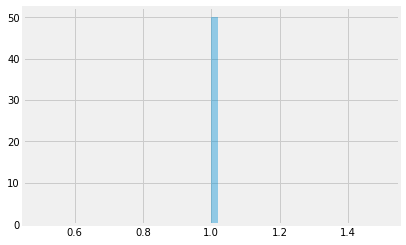

In [79]:
sns.distplot(sent_nums)
plt.show()

In [80]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [81]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

In [82]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 45582 unique tokens.


In [83]:
categories = wine_reviews['logit_score']
labels = pd.get_dummies(categories)

In [84]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (119955, 2, 72)
Shape of labels tensor: (119955, 2)


In [85]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.loc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of positive and negative reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
[0, 1]
[59510, 36454]
[14866, 9125]


In [86]:
#model 
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [87]:
import os

In [88]:
GLOVE_DIR = "../glove6b100dtxt/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf-8')
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [89]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 21808 which is 47.84 % of total words


In [90]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [91]:
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(40, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


TypeError: TF_SessionRun_wrapper: expected all values in input dict to be ndarray

### Clustering by reviewer

In [111]:
# Solution
df_1 = wine_reviews.groupby(['taster_name'])['logit_score'].sum()
df_1
#df_1 = df_1.unstack().fillna(0)
#df_1['Total_Sales'] = df_1['Prod1'].add(df_1['Prod2'])
#df_1 = df_1.sort_values('Total_Sales', ascending=False)[:10]

#df_1.iloc[:, :2].plot(kind='bar', stacked=True)
#plt.ylabel('Sales Amount, $')
#plt.show()

taster_name
Alexander Peartree      12
Anna Lee C. Iijima    1356
Anne Krebiehl MW      2198
Carrie Dykes             5
Christina Pickard        1
Fiona Adams              1
Jeff Jenssen           108
Jim Gordon            1506
Joe Czerwinski        1893
Kerin O’Keefe         3493
Lauren Buzzeo          469
Matt Kettmann         3385
Michael Schachner     2862
Mike DeSimone          219
Paul Gregutt          4113
Roger Voss            9623
Sean P. Sullivan      1738
Susan Kostrzewa        127
Virginie Boone        4638
Name: logit_score, dtype: int64

In [112]:
df_1.name = "good_rev"

In [113]:
df_1

taster_name
Alexander Peartree      12
Anna Lee C. Iijima    1356
Anne Krebiehl MW      2198
Carrie Dykes             5
Christina Pickard        1
Fiona Adams              1
Jeff Jenssen           108
Jim Gordon            1506
Joe Czerwinski        1893
Kerin O’Keefe         3493
Lauren Buzzeo          469
Matt Kettmann         3385
Michael Schachner     2862
Mike DeSimone          219
Paul Gregutt          4113
Roger Voss            9623
Sean P. Sullivan      1738
Susan Kostrzewa        127
Virginie Boone        4638
Name: good_rev, dtype: int64

In [118]:
df_2 = wine_reviews.groupby(['taster_name']).size()
df_2.name = "total_rev"
df_2

taster_name
Alexander Peartree      383
Anna Lee C. Iijima     4017
Anne Krebiehl MW       3289
Carrie Dykes            129
Christina Pickard         6
Fiona Adams              24
Jeff Jenssen            436
Jim Gordon             3766
Joe Czerwinski         4765
Kerin O’Keefe          9679
Lauren Buzzeo          1700
Matt Kettmann          5729
Michael Schachner     14045
Mike DeSimone           461
Paul Gregutt           8867
Roger Voss            23558
Sean P. Sullivan       4460
Susan Kostrzewa        1022
Virginie Boone         8707
Name: total_rev, dtype: int64

In [120]:
df_3 = df_1.to_frame().join(df_2)

In [121]:
df_3

,good_rev,total_rev
taster_name,,
Alexander Peartree,12,383
Anna Lee C. Iijima,1356,4017
Anne Krebiehl MW,2198,3289
Carrie Dykes,5,129
Christina Pickard,1,6
Fiona Adams,1,24
Jeff Jenssen,108,436
Jim Gordon,1506,3766
Joe Czerwinski,1893,4765


In [122]:
df_3['bad_rev'] = df_3['total_rev'] - df_3['good_rev']
df_3

,good_rev,total_rev,bad_rev
taster_name,,,
Alexander Peartree,12,383,371
Anna Lee C. Iijima,1356,4017,2661
Anne Krebiehl MW,2198,3289,1091
Carrie Dykes,5,129,124
Christina Pickard,1,6,5
Fiona Adams,1,24,23
Jeff Jenssen,108,436,328
Jim Gordon,1506,3766,2260
Joe Czerwinski,1893,4765,2872


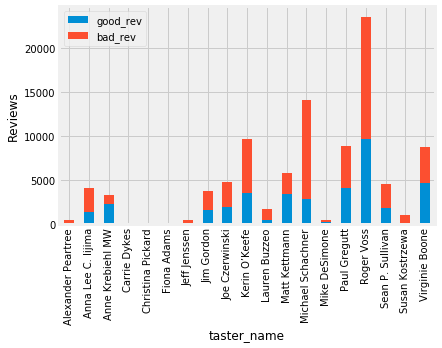

In [127]:
df_3.iloc[:, :3:2].plot(kind='bar', stacked=True)
plt.ylabel('Reviews')
plt.show()